In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.sans-serif'] = "Helvetica Neue"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'errorbar.capsize': 3})


# DataFrame Inspection
Here doing the good practice head, info, describe to help understand what is in the dataframe.

In [2]:
df = pd.read_csv('data/parsed_chase.csv')
df.head()

,Series,Episode,AirDate,Chaser,P1,P2,P3,P4,NPlayers,PTotal,playerScore,chaserScore,playerWin,remainingTime
0,7,1,2013-09-02,Anne Hegerty,3000.0,0.0,0.0,3000.0,2.0,6000.0,14,14,False,47.0
1,7,2,2013-09-03,Mark Labbett,7000.0,6000.0,5000.0,42000.0,4.0,60000.0,19,18,True,0.0
2,7,3,2013-09-04,Shaun Wallace,1000.0,0.0,0.0,49000.0,2.0,50000.0,17,17,False,2.0
3,7,4,2013-09-05,Mark Labbett,0.0,30000.0,-3000.0,7000.0,2.0,34000.0,19,19,False,6.0
4,7,5,2013-09-06,Paul Sinha,0.0,0.0,4000.0,5000.0,2.0,9000.0,11,11,False,61.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series         1454 non-null   int64  
 1   Episode        1454 non-null   int64  
 2   AirDate        1453 non-null   object 
 3   Chaser         1454 non-null   object 
 4   P1             1454 non-null   float64
 5   P2             1454 non-null   float64
 6   P3             1454 non-null   float64
 7   P4             1454 non-null   float64
 8   NPlayers       1454 non-null   float64
 9   PTotal         1454 non-null   float64
 10  playerScore    1454 non-null   int64  
 11  chaserScore    1454 non-null   int64  
 12  playerWin      1454 non-null   bool   
 13  remainingTime  1454 non-null   float64
dtypes: bool(1), float64(7), int64(4), object(2)
memory usage: 149.2+ KB


In [4]:
df.describe()

,Series,Episode,P1,P2,P3,P4,NPlayers,PTotal,playerScore,chaserScore,remainingTime
count,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000
mean,9.031637,78.259972,4365.887895,4760.039890,3017.782669,6008.150619,2.372077,18242.645117,16.281293,15.377579,22.243466
std,2.829467,50.542955,5893.332595,7319.953471,6479.031068,14544.849298,0.972331,16569.270265,3.651730,3.395445,21.137342
min,2.000000,1.000000,0.000000,-2000.000000,-6000.000000,-15000.000000,0.000000,0.000000,3.000000,3.000000,0.000000
25%,7.000000,34.000000,0.000000,0.000000,0.000000,0.000000,2.000000,8000.000000,14.000000,13.000000,1.000000
50%,9.000000,74.000000,4000.000000,4000.000000,300.000000,1000.000000,2.000000,13000.000000,16.000000,15.000000,19.000000
75%,11.000000,119.000000,6000.000000,6000.000000,5000.000000,6000.000000,3.000000,20000.000000,19.000000,18.000000,37.000000
max,13.000000,200.000000,40000.000000,50000.000000,50000.000000,101000.000000,4.000000,101000.000000,28.000000,27.000000,108.000000


# Win Rate Plots

First let's study how these parameters influence the chance of contestants winning.

## Generic WinRate Plotting Function

Here define a function that takes in a pandas groupby object, calculates the win rate for each group, then plots.

In [5]:
def plot_groupby_winrates(chasers_group, figsize=(8,4), dpi=200, label=None, xlabel=None, ylabel=None, xlim=None, ylim=None):
    """
    Given a pandas groupby object, produce a plot of contestant win rate split by group.
    Additional inputs for plotting labels.
    """
    
    fig, ax=plt.subplots(dpi=dpi)
        
    # Calculate win rate. Using binomial fraction calculation, output in percentage
    winrate_df = pd.DataFrame()
    winrate_df["winRate"] = chasers_group["playerWin"].sum()/chasers_group["playerWin"].count()
    winrate_df["winRateErr"] = (winrate_df["winRate"]*(1-winrate_df["winRate"])/chasers_group["playerWin"].count())**0.5
    winrate_df["winRate"] = winrate_df["winRate"]*100
    winrate_df["winRateErr"] = winrate_df["winRateErr"]*100
    
    # Assign an index label for each group
    plot_index = list(chasers_group.groups.keys())
    plot_index = [x.mid if type(x) == pd._libs.interval.Interval else x for x in plot_index]
    winrate_df = winrate_df.reset_index(drop=True)
    winrate_df["plot_index"] = plot_index

    winrate_df.plot(
        kind="scatter", marker='s', s=8, 
        x="plot_index", y="winRate", yerr="winRateErr", 
        figsize=figsize, xlim = xlim, ylim=ylim, ax=ax
    )
    
    
    if label != None:
        ax.legend([label])
    
    plt.xlabel(xlabel, horizontalalignment='right', x=1.0)
    plt.ylabel(ylabel, horizontalalignment='left', x=1.0)
    
    ax.tick_params(direction='in', length=2 )
    #ax.tick_params(axis="x", labelsize=8)
    #ax.tick_params(axis="y", labelsize=8)
    
    plt.show()

## Win Rate by Chaser

First we want to visualise the contestant win rates when facing each chaser. What we see immediately is that there is some variablity here

Contestants are...
- Least successful against Anne Hegerty 
- Most successful against Shaun Wallace


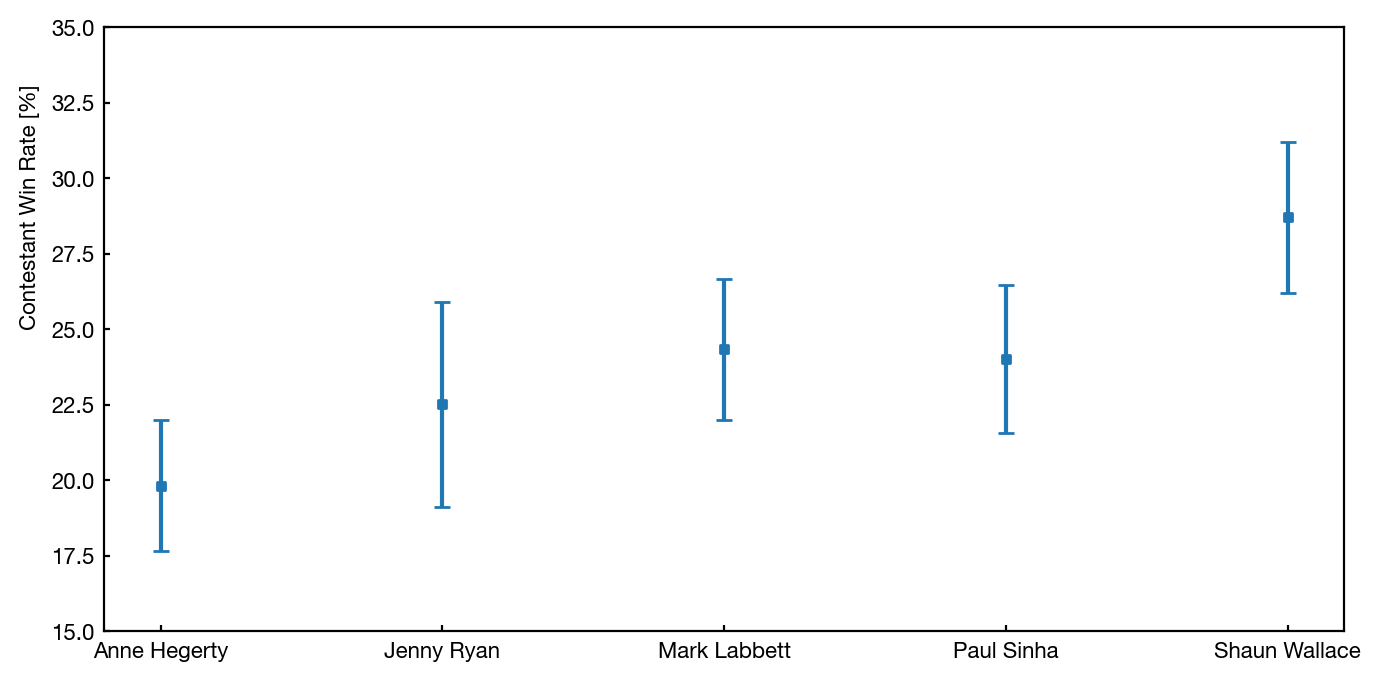

In [6]:
plot_groupby_winrates(df.groupby(['Chaser']), ylabel="Contestant Win Rate [%]", ylim=[15,35], figsize=(8,4), dpi=200)

## Win Rate by Number of Contestants in Final Chase

Next let's visualise the contestant win rates vs how many contestants are in the final chase.

Generally we see the more contestants there are, the higher success rate. This catches two effects:
- Each succesfull contestant is awared a 1 question headstart, with all 4 succesful they begin with a score of 4 already achieved.
- If all contestants are in the Final Chase, they were all smart enough to beat the chaser in their individual round.

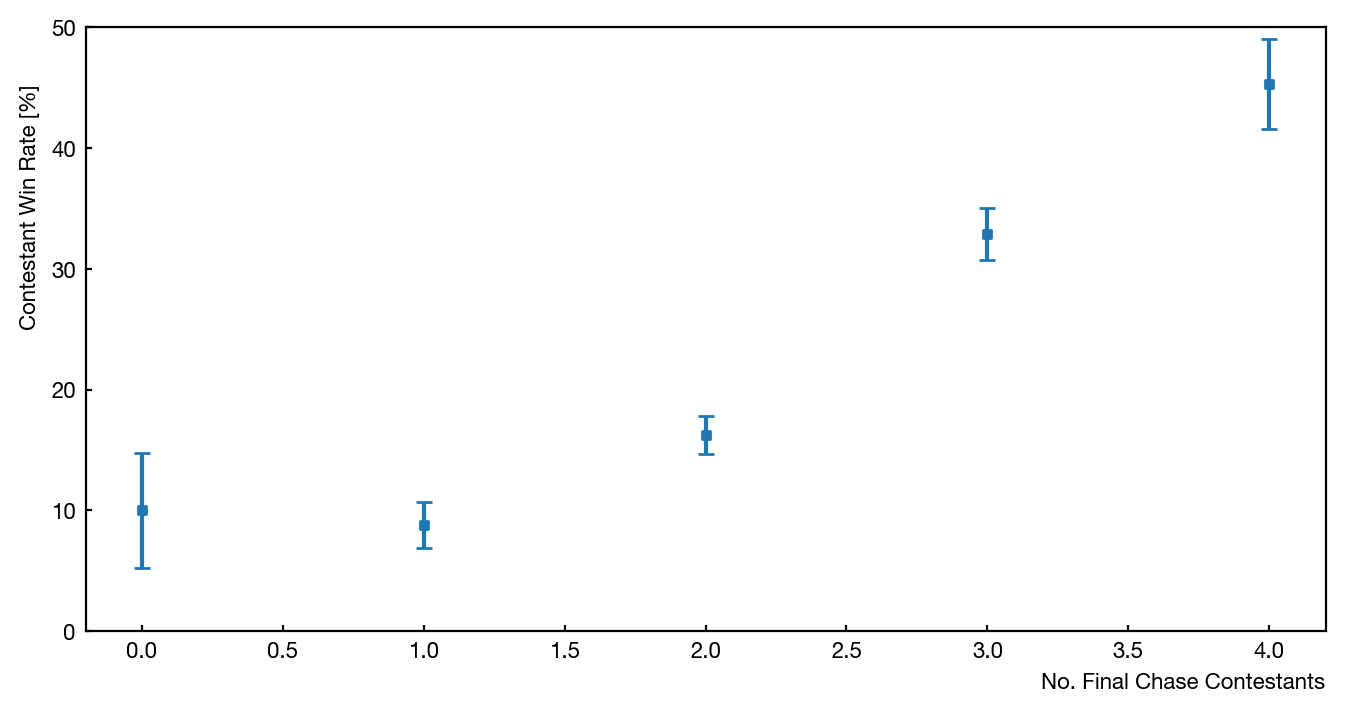

In [7]:
plot_groupby_winrates(df.groupby(['NPlayers']), xlabel="No. Final Chase Contestants", ylabel="Contestant Win Rate [%]", ylim=[0,50], figsize=(8,4), dpi=200)

## Win Rate by Contestant Final Chase Score

Next let's visualise the contestant win rates vs their score in the final chase. This is quite easy to get a good feeling for just by watching. The higher the score, the more work the Chaser needs to put in to win.

This is reflected quite well, with a strong slope arising after a score of around 15, below which the chance of winning is essentially zero.

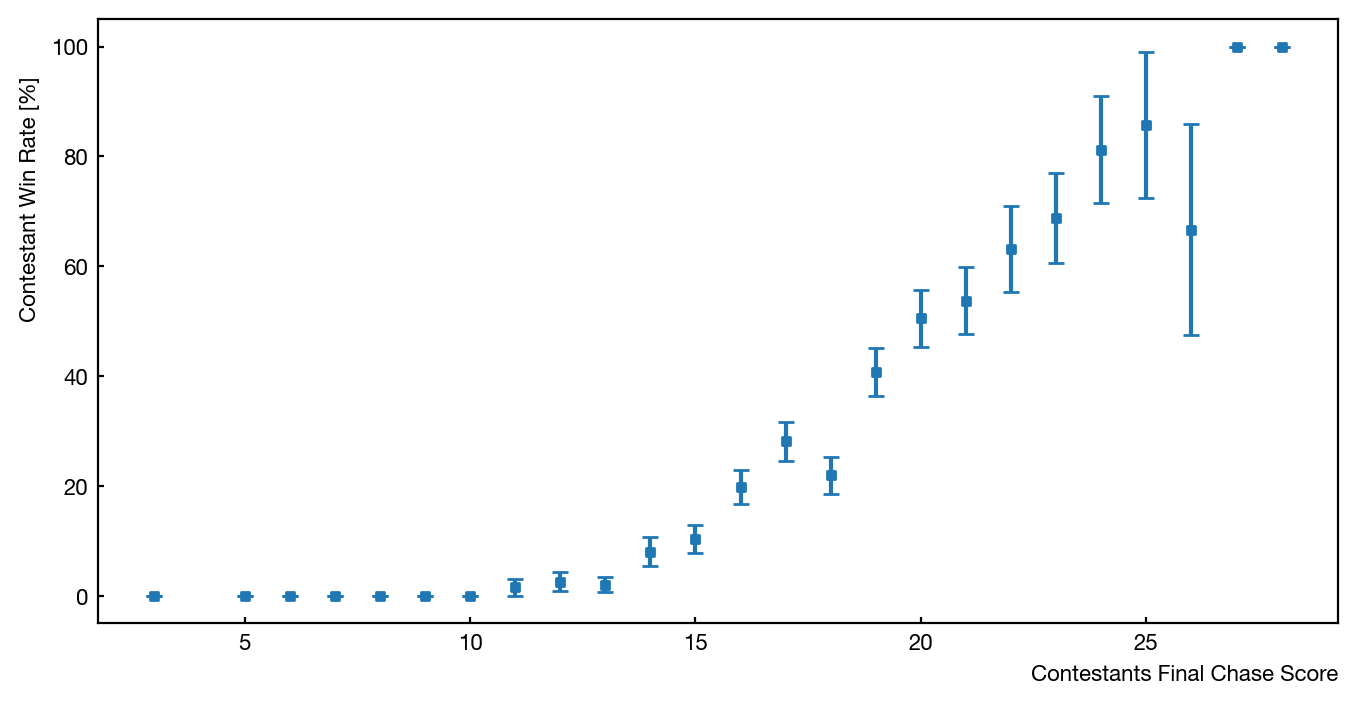

In [8]:
plot_groupby_winrates(df.groupby(['playerScore']), xlabel="Contestants Final Chase Score", ylabel="Contestant Win Rate [%]", figsize=(8,4), dpi=200)

### Per Chaser Notes?

Producing this plot for each chaser some interesting results arise. This dip at score=18 seems to be strongly influenced by Mark Labbett, and mildly also by Jenny Ryan. It is however only ~2sigma so not something to read into too much.

We also see Shaun Wallace has a distribution that differs from the others, at score=21-23 the player win-rates are curiously lower than the others, but for the bulk region score=15-20 the players have a much stronger chance of winning in comparison with other chasers.

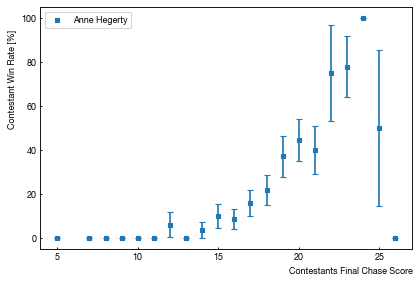

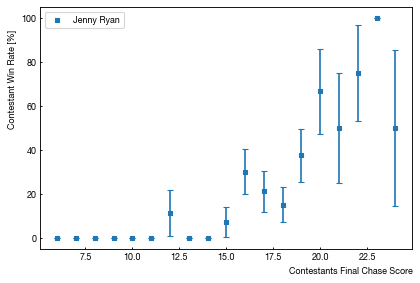

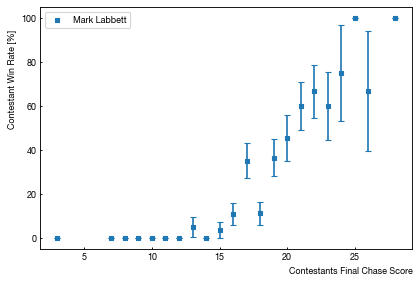

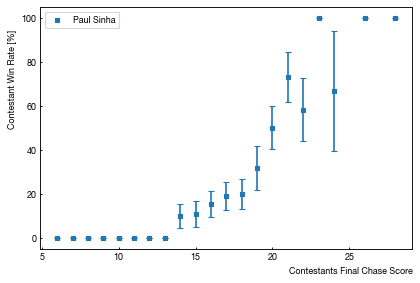

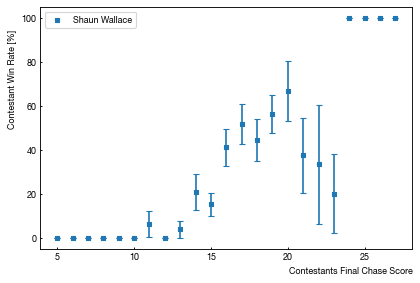

In [9]:
chasers = ["Anne Hegerty", "Jenny Ryan", "Mark Labbett", "Paul Sinha", "Shaun Wallace"]
for c in chasers:
    plot_groupby_winrates(df[df["Chaser"] == c].groupby(['playerScore']), label=c, xlabel="Contestants Final Chase Score", ylabel="Contestant Win Rate [%]", figsize=(6,4), dpi=80)
plt.show()